### Import Libraries

In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST, FashionMNIST
from torch.autograd import Variable

import numpy as np
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
root = '/'
seed = 999
batch_size = 256
latent_dim = 2
epochs = 20
lr = 1e-3

In [4]:
torch.manual_seed(seed)

### Model Architecture

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Reshape(nn.Module):
    def __init__(self, out_dim):
        super(Reshape, self).__init__()
        self.out_dim = out_dim

    def forward(self, x):
        return x.view(x.size(0), *self.out_dim)

In [6]:
# Encoder and Decoder from DC-GAN architecture
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.model = nn.ModuleList([
            # channel x 28 x 28
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            # conv layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(128 * 7 * 7, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, latent_dim)
        ])

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.model = nn.ModuleList([
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.ReLU(),
            Reshape((128, 7, 7)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

class MMD_VAE(nn.Module):
    def __init__(self, latent_dim):
        super(MMD_VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [7]:
# init model
model = MMD_VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [8]:
z, x_reconstructed = model(Variable(torch.rand(1, 1, 28, 28)))
z.size(), x_reconstructed.size()

(torch.Size([1, 2]), torch.Size([1, 1, 28, 28]))

In [9]:
# Convert np arr of shape [batch, height, width, 1] into
# a displayable arr of shape [height*sqrt(batch), width*sqrt(batch)]
# or [height*channel, width*channel]
def convert_to_display(samples):
    c, h, w = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3]) # -> [height, batch, width, 1]
    samples = np.reshape(samples, [h, c, c, w]) # -> [height, channel, channel, width]
    samples = np.transpose(samples, axes=[1, 0, 2, 3]) # -> [channel, height, channel, width]
    samples = np.reshape(samples, [h * c, w * c])
    return samples

# Rbf kernel
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # [x_size, 1, dim]
    y = y.unsqueeze(0) # [1, y_size, dim]
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
    return torch.exp(-kernel_input) # return size: [x_size, y_size]

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
    return mmd

In [10]:
def loss_function(x_recon, x, z):
    true_samples = torch.randn(batch_size, latent_dim, requires_grad=False).to(device)
    mmd = compute_mmd(true_samples, z)
    nll = (x_recon - x).pow(2).mean()
    loss = mmd + nll
    return loss, nll, mmd

def train(
    data_loader,
    latent_dim=2,
    epochs=10,
    use_cuda=True,
    log_interval=100,
    plot_interval=500
):
    train_loss = 0
    model = MMD_VAE(latent_dim)
    if use_cuda:
        model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    i = -1

    for epoch in range(epochs):
        for imgs, labels in data_loader:
            i += 1
            optimizer.zero_grad()

            x = Variable(imgs, requires_grad=False)
            if use_cuda:
                x = x.cuda()
            z, x_recon = model(x)
            loss, nll, mmd = loss_function(x_recon, x, z)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if i % log_interval == 0:
                print(f'Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Negative Log Likelihood: {nll.item():.4f} | MMD Loss: {mmd.item():.4f}')

            if i % plot_interval == 0:
                gen_z = Variable(torch.randn(100, latent_dim), requires_grad=False)
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0, 2, 3, 1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()

        print(f'====> Epoch: {epoch+1} | Average Loss: {train_loss / len(data_loader.dataset):.4f}')
    return model

### Train on MNIST

In [11]:
%%time
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root, train=True, transform=mnist_transforms, download=True)
test_dataset = MNIST(root, train=False, transform=mnist_transforms, download=True)

mnist_train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3,
    pin_memory=True)

CPU times: user 8.8 ms, sys: 85.9 ms, total: 94.7 ms
Wall time: 220 ms


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 | Loss: 0.4138 | Negative Log Likelihood: 0.2529 | MMD Loss: 0.1609


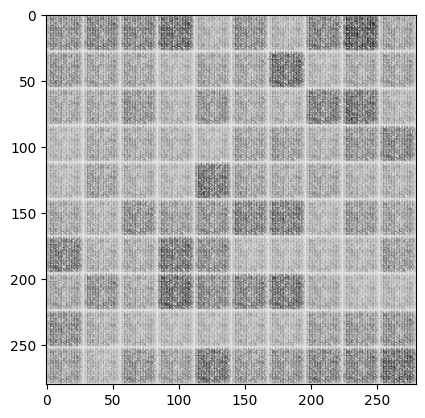

Epoch 1/20 | Loss: 0.2404 | Negative Log Likelihood: 0.0681 | MMD Loss: 0.1723
Epoch 1/20 | Loss: 0.2492 | Negative Log Likelihood: 0.0667 | MMD Loss: 0.1825
====> Epoch: 1 | Average Loss: 0.0009
Epoch 2/20 | Loss: 0.2466 | Negative Log Likelihood: 0.0686 | MMD Loss: 0.1780
Epoch 2/20 | Loss: 0.2657 | Negative Log Likelihood: 0.0669 | MMD Loss: 0.1988
====> Epoch: 2 | Average Loss: 0.0019
Epoch 3/20 | Loss: 0.1091 | Negative Log Likelihood: 0.0612 | MMD Loss: 0.0479


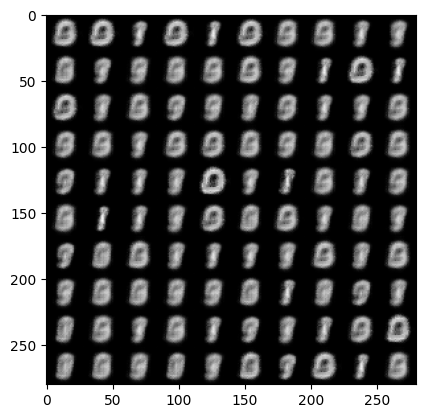

Epoch 3/20 | Loss: 0.1024 | Negative Log Likelihood: 0.0595 | MMD Loss: 0.0429
Epoch 3/20 | Loss: 0.0667 | Negative Log Likelihood: 0.0513 | MMD Loss: 0.0154
====> Epoch: 3 | Average Loss: 0.0023
Epoch 4/20 | Loss: 0.0535 | Negative Log Likelihood: 0.0493 | MMD Loss: 0.0042
Epoch 4/20 | Loss: 0.0626 | Negative Log Likelihood: 0.0503 | MMD Loss: 0.0123
====> Epoch: 4 | Average Loss: 0.0025
Epoch 5/20 | Loss: 0.0533 | Negative Log Likelihood: 0.0470 | MMD Loss: 0.0064


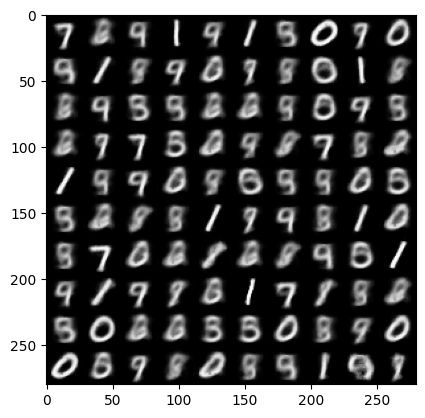

Epoch 5/20 | Loss: 0.0510 | Negative Log Likelihood: 0.0467 | MMD Loss: 0.0043
====> Epoch: 5 | Average Loss: 0.0027
Epoch 6/20 | Loss: 0.0453 | Negative Log Likelihood: 0.0436 | MMD Loss: 0.0017
Epoch 6/20 | Loss: 0.0523 | Negative Log Likelihood: 0.0448 | MMD Loss: 0.0075
Epoch 6/20 | Loss: 0.0529 | Negative Log Likelihood: 0.0454 | MMD Loss: 0.0075
====> Epoch: 6 | Average Loss: 0.0029
Epoch 7/20 | Loss: 0.0448 | Negative Log Likelihood: 0.0426 | MMD Loss: 0.0022


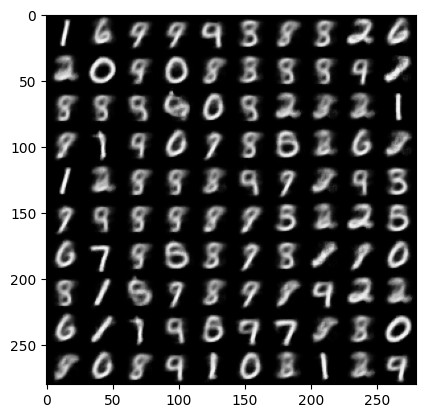

Epoch 7/20 | Loss: 0.0467 | Negative Log Likelihood: 0.0426 | MMD Loss: 0.0041
====> Epoch: 7 | Average Loss: 0.0031
Epoch 8/20 | Loss: 0.0426 | Negative Log Likelihood: 0.0406 | MMD Loss: 0.0019
Epoch 8/20 | Loss: 0.0414 | Negative Log Likelihood: 0.0403 | MMD Loss: 0.0011
====> Epoch: 8 | Average Loss: 0.0033
Epoch 9/20 | Loss: 0.0450 | Negative Log Likelihood: 0.0421 | MMD Loss: 0.0029
Epoch 9/20 | Loss: 0.0513 | Negative Log Likelihood: 0.0408 | MMD Loss: 0.0105


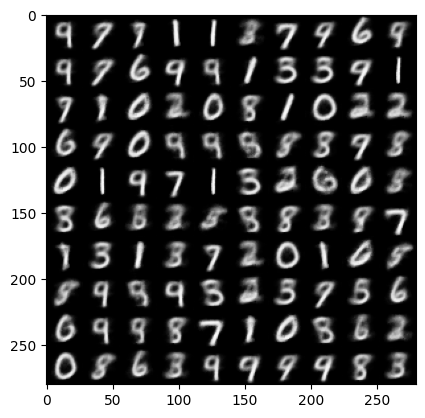

Epoch 9/20 | Loss: 0.0432 | Negative Log Likelihood: 0.0415 | MMD Loss: 0.0017
====> Epoch: 9 | Average Loss: 0.0034
Epoch 10/20 | Loss: 0.0428 | Negative Log Likelihood: 0.0415 | MMD Loss: 0.0013
Epoch 10/20 | Loss: 0.0462 | Negative Log Likelihood: 0.0386 | MMD Loss: 0.0076
====> Epoch: 10 | Average Loss: 0.0036
Epoch 11/20 | Loss: 0.0442 | Negative Log Likelihood: 0.0418 | MMD Loss: 0.0024
Epoch 11/20 | Loss: 0.0466 | Negative Log Likelihood: 0.0424 | MMD Loss: 0.0042


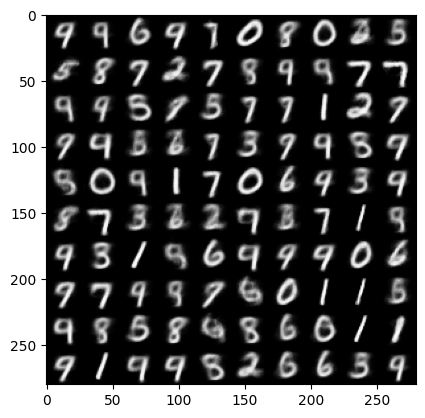

====> Epoch: 11 | Average Loss: 0.0038
Epoch 12/20 | Loss: 0.0437 | Negative Log Likelihood: 0.0391 | MMD Loss: 0.0045
Epoch 12/20 | Loss: 0.0470 | Negative Log Likelihood: 0.0405 | MMD Loss: 0.0065
Epoch 12/20 | Loss: 0.0447 | Negative Log Likelihood: 0.0397 | MMD Loss: 0.0050
====> Epoch: 12 | Average Loss: 0.0040
Epoch 13/20 | Loss: 0.0458 | Negative Log Likelihood: 0.0403 | MMD Loss: 0.0055
Epoch 13/20 | Loss: 0.0451 | Negative Log Likelihood: 0.0378 | MMD Loss: 0.0073


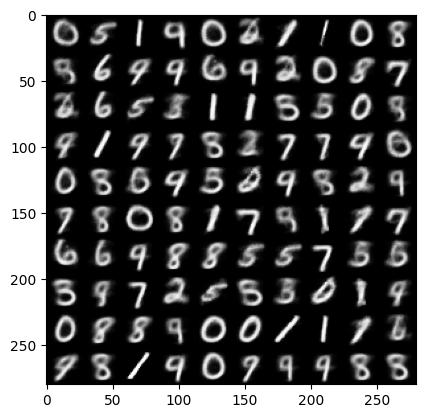

====> Epoch: 13 | Average Loss: 0.0041
Epoch 14/20 | Loss: 0.0425 | Negative Log Likelihood: 0.0374 | MMD Loss: 0.0051
Epoch 14/20 | Loss: 0.0428 | Negative Log Likelihood: 0.0402 | MMD Loss: 0.0025
====> Epoch: 14 | Average Loss: 0.0043
Epoch 15/20 | Loss: 0.0409 | Negative Log Likelihood: 0.0393 | MMD Loss: 0.0016
Epoch 15/20 | Loss: 0.0436 | Negative Log Likelihood: 0.0394 | MMD Loss: 0.0041
Epoch 15/20 | Loss: 0.0449 | Negative Log Likelihood: 0.0408 | MMD Loss: 0.0041


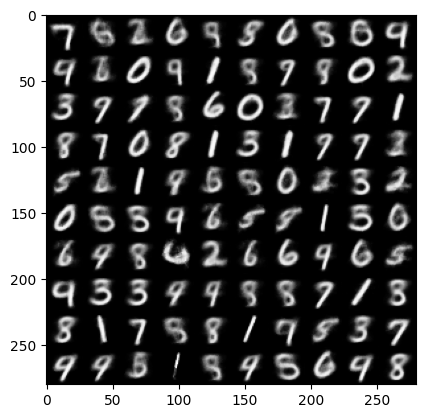

====> Epoch: 15 | Average Loss: 0.0045
Epoch 16/20 | Loss: 0.0432 | Negative Log Likelihood: 0.0392 | MMD Loss: 0.0040
Epoch 16/20 | Loss: 0.0417 | Negative Log Likelihood: 0.0383 | MMD Loss: 0.0034
====> Epoch: 16 | Average Loss: 0.0046
Epoch 17/20 | Loss: 0.0396 | Negative Log Likelihood: 0.0385 | MMD Loss: 0.0011
Epoch 17/20 | Loss: 0.0471 | Negative Log Likelihood: 0.0386 | MMD Loss: 0.0085
====> Epoch: 17 | Average Loss: 0.0048
Epoch 18/20 | Loss: 0.0454 | Negative Log Likelihood: 0.0388 | MMD Loss: 0.0067


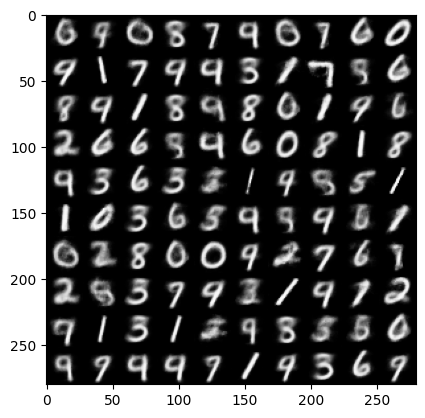

Epoch 18/20 | Loss: 0.0475 | Negative Log Likelihood: 0.0379 | MMD Loss: 0.0097
Epoch 18/20 | Loss: 0.0375 | Negative Log Likelihood: 0.0360 | MMD Loss: 0.0016
====> Epoch: 18 | Average Loss: 0.0050
Epoch 19/20 | Loss: 0.0429 | Negative Log Likelihood: 0.0385 | MMD Loss: 0.0045
Epoch 19/20 | Loss: 0.0393 | Negative Log Likelihood: 0.0388 | MMD Loss: 0.0005
====> Epoch: 19 | Average Loss: 0.0051
Epoch 20/20 | Loss: 0.0461 | Negative Log Likelihood: 0.0386 | MMD Loss: 0.0075


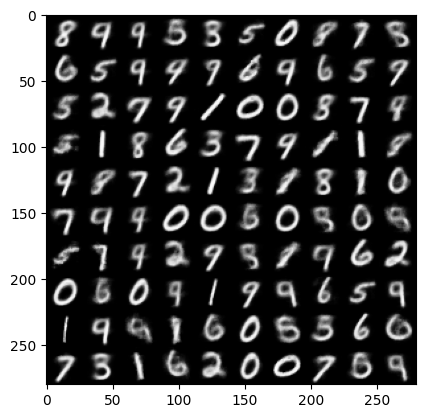

Epoch 20/20 | Loss: 0.0403 | Negative Log Likelihood: 0.0387 | MMD Loss: 0.0016
====> Epoch: 20 | Average Loss: 0.0053


In [12]:
model = train(mnist_train_loader, latent_dim=latent_dim, epochs=epochs)

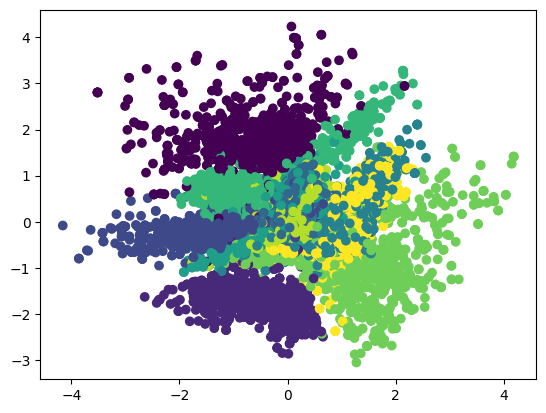

In [13]:
if latent_dim == 2:
    test_batch_size = 500
    z_list, label_list = [], []
    mnist_test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=test_batch_size,
        shuffle=True,
        num_workers=3,
        pin_memory=True)

    for i in range(20):
        batch_x, batch_y = next(iter(mnist_test_loader))
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()

### Train on Fashion MNIST

In [14]:
%%time
fashion_mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = FashionMNIST(root, train=True, transform=fashion_mnist_transforms, download=True)
test_dataset = FashionMNIST(root, train=False, transform=fashion_mnist_transforms, download=True)

fashion_mnist_train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3,
    pin_memory=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting /FashionMNIST/raw/train-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting /FashionMNIST/raw/train-labels-idx1-ubyte.gz to /FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.81MB/s]


Extracting /FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.1MB/s]

Extracting /FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /FashionMNIST/raw

CPU times: user 571 ms, sys: 297 ms, total: 868 ms
Wall time: 7.14 s


Epoch 1/20 | Loss: 0.3580 | Negative Log Likelihood: 0.1600 | MMD Loss: 0.1980


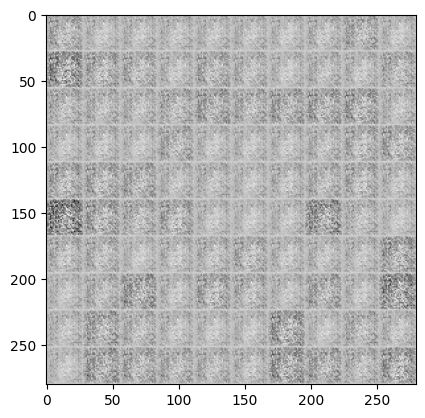

Epoch 1/20 | Loss: 0.1332 | Negative Log Likelihood: 0.0691 | MMD Loss: 0.0641
Epoch 1/20 | Loss: 0.0472 | Negative Log Likelihood: 0.0385 | MMD Loss: 0.0087
====> Epoch: 1 | Average Loss: 0.0006
Epoch 2/20 | Loss: 0.0390 | Negative Log Likelihood: 0.0362 | MMD Loss: 0.0028
Epoch 2/20 | Loss: 0.0384 | Negative Log Likelihood: 0.0348 | MMD Loss: 0.0037
====> Epoch: 2 | Average Loss: 0.0008
Epoch 3/20 | Loss: 0.0353 | Negative Log Likelihood: 0.0333 | MMD Loss: 0.0020


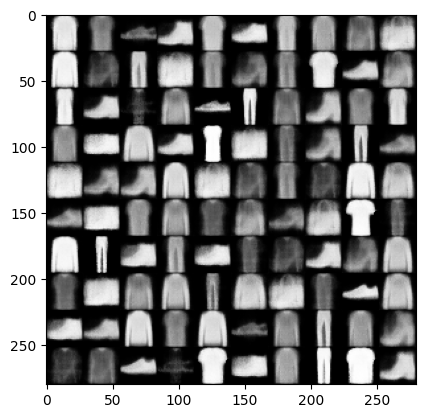

Epoch 3/20 | Loss: 0.0437 | Negative Log Likelihood: 0.0330 | MMD Loss: 0.0107
Epoch 3/20 | Loss: 0.0369 | Negative Log Likelihood: 0.0315 | MMD Loss: 0.0054
====> Epoch: 3 | Average Loss: 0.0009
Epoch 4/20 | Loss: 0.0350 | Negative Log Likelihood: 0.0340 | MMD Loss: 0.0010
Epoch 4/20 | Loss: 0.0328 | Negative Log Likelihood: 0.0301 | MMD Loss: 0.0027
====> Epoch: 4 | Average Loss: 0.0010
Epoch 5/20 | Loss: 0.0317 | Negative Log Likelihood: 0.0290 | MMD Loss: 0.0028


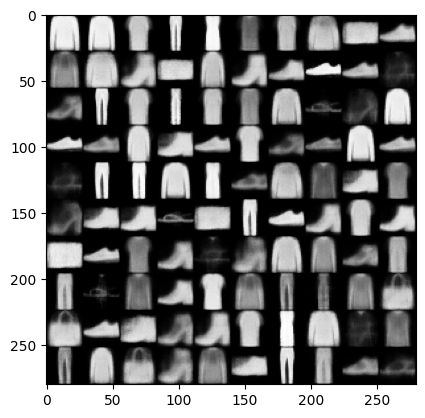

Epoch 5/20 | Loss: 0.0343 | Negative Log Likelihood: 0.0307 | MMD Loss: 0.0037
====> Epoch: 5 | Average Loss: 0.0012
Epoch 6/20 | Loss: 0.0393 | Negative Log Likelihood: 0.0343 | MMD Loss: 0.0051
Epoch 6/20 | Loss: 0.0318 | Negative Log Likelihood: 0.0289 | MMD Loss: 0.0030
Epoch 6/20 | Loss: 0.0377 | Negative Log Likelihood: 0.0306 | MMD Loss: 0.0071
====> Epoch: 6 | Average Loss: 0.0013
Epoch 7/20 | Loss: 0.0324 | Negative Log Likelihood: 0.0282 | MMD Loss: 0.0041


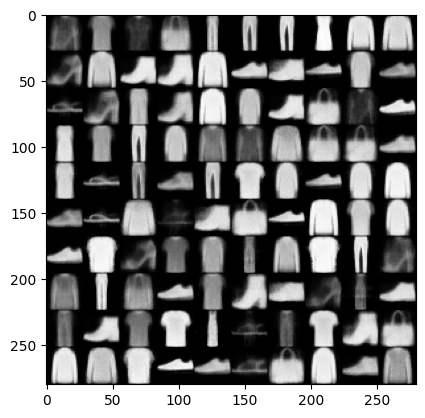

Epoch 7/20 | Loss: 0.0372 | Negative Log Likelihood: 0.0305 | MMD Loss: 0.0067
====> Epoch: 7 | Average Loss: 0.0015
Epoch 8/20 | Loss: 0.0338 | Negative Log Likelihood: 0.0305 | MMD Loss: 0.0033
Epoch 8/20 | Loss: 0.0327 | Negative Log Likelihood: 0.0292 | MMD Loss: 0.0036
====> Epoch: 8 | Average Loss: 0.0016
Epoch 9/20 | Loss: 0.0306 | Negative Log Likelihood: 0.0283 | MMD Loss: 0.0023
Epoch 9/20 | Loss: 0.0303 | Negative Log Likelihood: 0.0272 | MMD Loss: 0.0031


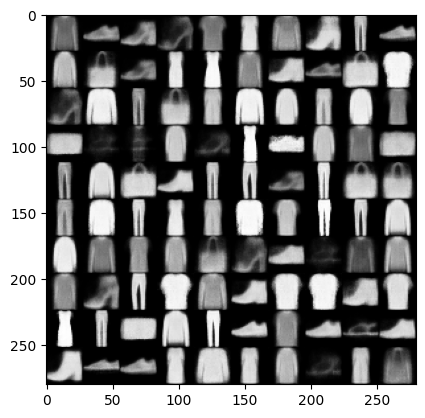

Epoch 9/20 | Loss: 0.0361 | Negative Log Likelihood: 0.0308 | MMD Loss: 0.0053
====> Epoch: 9 | Average Loss: 0.0017
Epoch 10/20 | Loss: 0.0308 | Negative Log Likelihood: 0.0279 | MMD Loss: 0.0029
Epoch 10/20 | Loss: 0.0326 | Negative Log Likelihood: 0.0286 | MMD Loss: 0.0039
====> Epoch: 10 | Average Loss: 0.0018
Epoch 11/20 | Loss: 0.0271 | Negative Log Likelihood: 0.0254 | MMD Loss: 0.0017
Epoch 11/20 | Loss: 0.0313 | Negative Log Likelihood: 0.0280 | MMD Loss: 0.0034


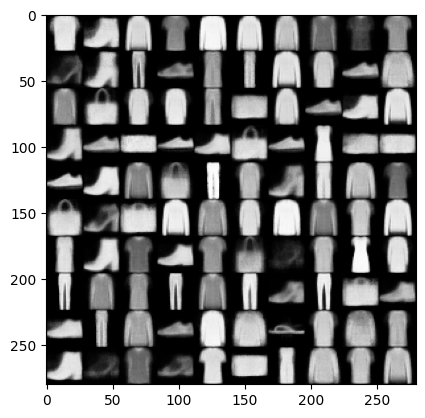

====> Epoch: 11 | Average Loss: 0.0020
Epoch 12/20 | Loss: 0.0304 | Negative Log Likelihood: 0.0273 | MMD Loss: 0.0031
Epoch 12/20 | Loss: 0.0312 | Negative Log Likelihood: 0.0302 | MMD Loss: 0.0009
Epoch 12/20 | Loss: 0.0331 | Negative Log Likelihood: 0.0261 | MMD Loss: 0.0070
====> Epoch: 12 | Average Loss: 0.0021
Epoch 13/20 | Loss: 0.0354 | Negative Log Likelihood: 0.0303 | MMD Loss: 0.0051
Epoch 13/20 | Loss: 0.0362 | Negative Log Likelihood: 0.0303 | MMD Loss: 0.0058


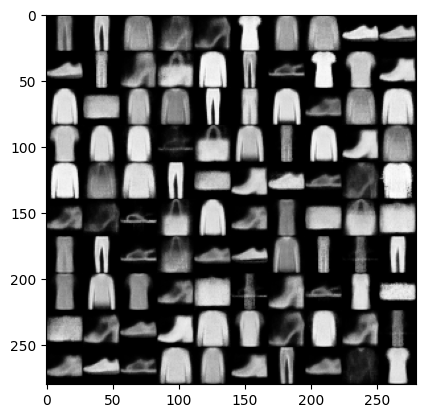

====> Epoch: 13 | Average Loss: 0.0022
Epoch 14/20 | Loss: 0.0301 | Negative Log Likelihood: 0.0276 | MMD Loss: 0.0024
Epoch 14/20 | Loss: 0.0331 | Negative Log Likelihood: 0.0264 | MMD Loss: 0.0066
====> Epoch: 14 | Average Loss: 0.0024
Epoch 15/20 | Loss: 0.0303 | Negative Log Likelihood: 0.0270 | MMD Loss: 0.0034
Epoch 15/20 | Loss: 0.0310 | Negative Log Likelihood: 0.0280 | MMD Loss: 0.0031
Epoch 15/20 | Loss: 0.0333 | Negative Log Likelihood: 0.0292 | MMD Loss: 0.0040


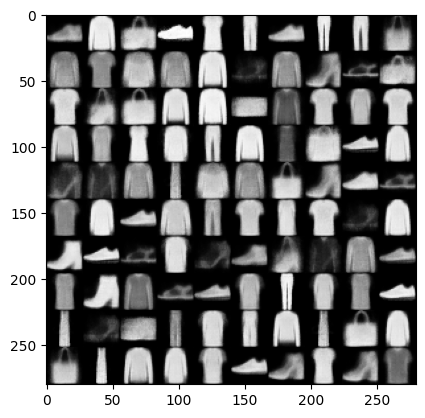

====> Epoch: 15 | Average Loss: 0.0025
Epoch 16/20 | Loss: 0.0354 | Negative Log Likelihood: 0.0277 | MMD Loss: 0.0077
Epoch 16/20 | Loss: 0.0310 | Negative Log Likelihood: 0.0260 | MMD Loss: 0.0050
====> Epoch: 16 | Average Loss: 0.0026
Epoch 17/20 | Loss: 0.0329 | Negative Log Likelihood: 0.0283 | MMD Loss: 0.0046
Epoch 17/20 | Loss: 0.0342 | Negative Log Likelihood: 0.0284 | MMD Loss: 0.0058
====> Epoch: 17 | Average Loss: 0.0027
Epoch 18/20 | Loss: 0.0283 | Negative Log Likelihood: 0.0260 | MMD Loss: 0.0023


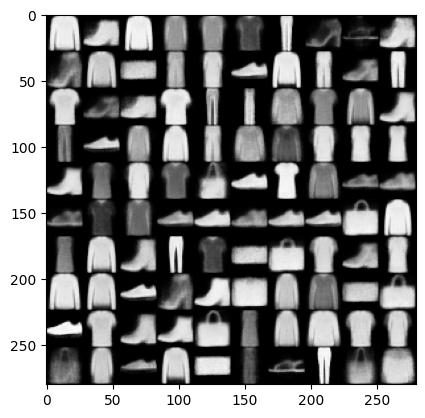

Epoch 18/20 | Loss: 0.0320 | Negative Log Likelihood: 0.0285 | MMD Loss: 0.0036
Epoch 18/20 | Loss: 0.0312 | Negative Log Likelihood: 0.0282 | MMD Loss: 0.0030
====> Epoch: 18 | Average Loss: 0.0029
Epoch 19/20 | Loss: 0.0291 | Negative Log Likelihood: 0.0271 | MMD Loss: 0.0020
Epoch 19/20 | Loss: 0.0392 | Negative Log Likelihood: 0.0268 | MMD Loss: 0.0124
====> Epoch: 19 | Average Loss: 0.0030
Epoch 20/20 | Loss: 0.0287 | Negative Log Likelihood: 0.0258 | MMD Loss: 0.0029


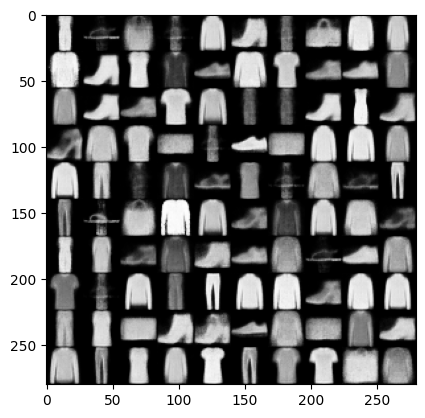

Epoch 20/20 | Loss: 0.0301 | Negative Log Likelihood: 0.0273 | MMD Loss: 0.0028
====> Epoch: 20 | Average Loss: 0.0031


In [15]:
model = train(fashion_mnist_train_loader, latent_dim=latent_dim, epochs=epochs)

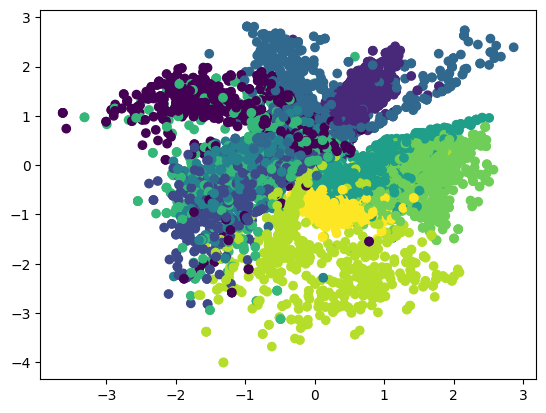

In [17]:
if latent_dim == 2:
    test_batch_size = 500
    z_list, label_list = [], []
    fashion_mnist_test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=test_batch_size,
        shuffle=True,
        num_workers=3,
        pin_memory=True)

    for i in range(20):
        batch_x, batch_y = next(iter(fashion_mnist_test_loader))
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()
